# Projeto Integrador III-B: Deep Learning para Classificação de Linhas de Transporte Intermunicipal

## Pontifícia Universidade Católica de Goiás - Escola Politécnica
### Curso: Big Data e Inteligência Artificial

**Autores:**
- Fellipy Bernardes da Silva
- Fernanda Santalucia Bonjardim
- Hellen Almeida de Oliveira
- Hugo de Assis Furtado
- Vitória Gonçalves Lordeiro

**Concedente:** Agência Goiana de Regulação, Controle e Fiscalização de Serviços Públicos (AGR)

---

## Objetivo

Este notebook implementa uma solução de **Deep Learning** utilizando um **Perceptron Multicamadas (MLP)** para classificar o tipo de linha de transporte intermunicipal de passageiros no Estado de Goiás.

### Classes de Classificação:
- **Convencional**: Linhas regulares de transporte intermunicipal
- **Semiurbano**: Serviços de curta distância entre municípios próximos
- **Expresso**: Serviços com menos paradas, mais rápidos
- **Viagens Diretas**: Sem paradas intermediárias
- **Viagens Semidiretas**: Com poucas paradas intermediárias


## 1. Importação das Bibliotecas


In [51]:
# Instalação das dependências (descomentar e executar se necessário)
# !pip install pandas numpy scikit-learn tensorflow matplotlib seaborn


In [52]:
# Bibliotecas para manipulação de dados
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Bibliotecas para Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Configurações de exibição
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow versão: {tf.__version__}")
print(f"NumPy versão: {np.__version__}")
print(f"Pandas versão: {pd.__version__}")


TensorFlow versão: 2.20.0
NumPy versão: 2.3.5
Pandas versão: 2.3.3


## 2. Carregamento dos Dados

Os dados são provenientes do Portal de Dados Abertos do Estado de Goiás, disponibilizados pela AGR (Agência Goiana de Regulação).


In [53]:
# Carregamento do dataset principal: empresas e linhas autorizadas
df_empresas = pd.read_csv(
    'empresas-autorizadas-termos-de-autorizacao-e-precos-de-passagens-.csv',
    sep=';',
    encoding='latin-1'
)

# Carregamento do dataset de tarifas
df_tarifas = pd.read_csv(
    'reajuste-de-tarifas-de-transporte-rodoviario-intermunicipal-6.csv',
    sep=';',
    encoding='latin-1'
)

# Carregamento do dataset de terminais
df_terminais = pd.read_csv(
    'terminais-rodoviarios-de-passageiros-6.csv',
    sep=';',
    encoding='latin-1'
)

print("Datasets carregados com sucesso!")
print(f"\n- Empresas e Linhas: {df_empresas.shape[0]} registros, {df_empresas.shape[1]} colunas")
print(f"- Tarifas: {df_tarifas.shape[0]} registros, {df_tarifas.shape[1]} colunas")
print(f"- Terminais: {df_terminais.shape[0]} registros, {df_terminais.shape[1]} colunas")


Datasets carregados com sucesso!

- Empresas e Linhas: 285 registros, 4 colunas
- Tarifas: 102 registros, 6 colunas
- Terminais: 194 registros, 6 colunas


## 3. Análise Exploratória de Dados (EDA)


In [54]:
# Visualização das primeiras linhas - Dataset de Empresas
print("=" * 80)
print("DATASET: EMPRESAS AUTORIZADAS E LINHAS")
print("=" * 80)
print(f"\nColunas: {df_empresas.columns.tolist()}")
df_empresas.head(10)


DATASET: EMPRESAS AUTORIZADAS E LINHAS

Colunas: ['NOME DA EMPRESA', 'NÚMERO DA LINHA', 'ITINERÁRIO', 'ARQUIVO']


,NOME DA EMPRESA,NÚMERO DA LINHA,ITINERÁRIO,ARQUIVO
0,Araguatur Viagens e Turismo EIRELI ME,1959.162-00,Goiânia a São Miguel do Araguaia (via GO-070 e GO-164),Linha nº 1959.162-00 Goiânia a São Miguel do Araguaia (via GO-070 e GO-164)
1,Auto Viação Goianésia Ltda.,01.044-00,Goiânia a Adelândia,Linha nº 01.044-00  Goiânia a Adelândia
2,Auto Viação Goianésia Ltda.,01.045-00,Goiânia a Americano do Brasil,Linha nº 01.045-00  Goiânia a Americano do Brasil
3,Auto Viação Goianésia Ltda.,01.046-00,Goiânia a Aruanã,Linha nº 01.046-00  Goiânia a Aruanã
4,Auto Viação Goianésia Ltda.,01.047-00,Goiânia a Britânia (via GO-060 e GO-326),Linha nº 01.047-00  Goiânia a Britânia (via GO-060 e GO-326)
5,Auto Viação Goianésia Ltda.,01.048-00,Goiânia a Jussara,Linha nº 01.048-00  Goiânia a Jussara
6,Auto Viação Goianésia Ltda.,01.049-00,Goiânia a Novo Brasil,Linha nº 01.049-00  Goiânia a Novo Brasil
7,Auto Viação Goianésia Ltda.,01.050-00,Goiânia a Anicuns,Linha nº 01.050-00  Goiânia a Anicuns
8,Auto Viação Goianésia Ltda.,01.051-00,Goiânia a Claudinápolis,Linha nº 01.051-00  Goiânia a Claudinápolis
9,Auto Viação Goianésia Ltda.,01.052-00,Goiânia a Santa Bárbara de Goiás,Linha nº 01.052-00  Goiânia a Santa Bárbara de Goiás


In [55]:
# Visualização das primeiras linhas - Dataset de Tarifas
print("=" * 80)
print("DATASET: REAJUSTE DE TARIFAS")
print("=" * 80)
print(f"\nColunas: {df_tarifas.columns.tolist()}")
df_tarifas.head(10)


DATASET: REAJUSTE DE TARIFAS

Colunas: ['ANO', 'ICMS', 'Tipo de Serviço', 'Fator de Correlação Tarifária', 'Coeficientes Tarifários (R$/Pas*km)', 'RESOLUÇÃO']


,ANO,ICMS,Tipo de Serviço,Fator de Correlação Tarifária,Coeficientes Tarifários (R$/Pas*km),RESOLUÇÃO
0,2024,SEM,"Serviço Convencional, em rodovia tipo I (rodovia pavimentada)",NaN,"0,305343",Reajuste Tarifário 2024
1,2024,SEM,"Serviço Convencional, em rodovia tipo II (rodovia encascalhada)","1,31984 x convencional tipo I","0,403004",Reajuste Tarifário 2024
2,2024,SEM,"Serviço Convencional, em rodovia tipo III (rodovia pioneira)","1,50352 x convencional tipo I","0,459089",Reajuste Tarifário 2024
3,2024,SEM,Serviço Expresso,"1,24097 x convencional tipo I","0,378922",Reajuste Tarifário 2024
4,2024,SEM,Serviço Semileito,"1,37000 x convencional tipo I","0,41832",Reajuste Tarifário 2024
5,2024,SEM,Serviço Leito,"2,27000 x convencional tipo I","0,693129",Reajuste Tarifário 2024
6,2024,SEM,Serviço Semiurbano,"0,74146 x convencional tipo I","0,2264",Reajuste Tarifário 2024
7,2024,19%,"Serviço Convencional, em rodovia tipo I (rodovia pavimentada)",NaN,"0,376967",Reajuste Tarifário 2024
8,2024,19%,"Serviço Convencional, em rodovia tipo II (rodovia encascalhada)","1,31984 x convencional tipo I","0,497536",Reajuste Tarifário 2024
9,2024,19%,"Serviço Convencional, em rodovia tipo III (rodovia pioneira)","1,50352 x convencional tipo I","0,566777",Reajuste Tarifário 2024


In [56]:
# Visualização das primeiras linhas - Dataset de Terminais
print("=" * 80)
print("DATASET: TERMINAIS RODOVIÁRIOS")
print("=" * 80)
print(f"\nColunas: {df_terminais.columns.tolist()}")
df_terminais.head(10)


DATASET: TERMINAIS RODOVIÁRIOS

Colunas: ['Município', 'Propriedade', 'Entidade Gestora', 'Situação', 'Convênio', 'Vigência']


,Município,Propriedade,Entidade Gestora,Situação,Convênio,Vigência
0,Abadiânia,Estado,GEPIT/SGG,OPERANDO,NÃO,
1,Acreúna,Estado,GEPIT/SGG,OPERANDO,SIM,30/08/2022
2,Adelândia,Estado,GEPIT/SGG,OPERANDO,NÃO,
3,Água Fria,Estado,GEPIT/SGG,OPERANDO,NÃO,
4,Água Limpa,Estado,GEPIT/SGG,OPERANDO,NÃO,
5,Alexânia,Estado,GEPIT/SGG,OPERANDO,SIM,02/04/2024
6,Aloândia,Estado,GEPIT/SGG,OPERANDO,NÃO,
7,Alto Horizonte,Estado,GEPIT/SGG,OPERANDO,SIM,10/08/2022
8,Alto Paraíso de Goiás,Estado,GEPIT/SGG,OPERANDO,VENCIDO,20/05/2022
9,Alvorada do Norte,Estado,GEPIT/SGG,OPERANDO,VENCIDO,16/06/2022


In [57]:
# Informações estatísticas e valores nulos
print("\n" + "=" * 80)
print("INFORMAÇÕES DO DATASET DE EMPRESAS")
print("=" * 80)
print(df_empresas.info())

print("\n" + "=" * 80)
print("VALORES NULOS POR DATASET")
print("=" * 80)
print("\nEmpresas:")
print(df_empresas.isnull().sum())
print("\nTarifas:")
print(df_tarifas.isnull().sum())
print("\nTerminais:")
print(df_terminais.isnull().sum())



INFORMAÇÕES DO DATASET DE EMPRESAS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   NOME DA EMPRESA  285 non-null    object
 1   NÚMERO DA LINHA  285 non-null    object
 2   ITINERÁRIO       285 non-null    object
 3   ARQUIVO          285 non-null    object
dtypes: object(4)
memory usage: 9.0+ KB
None

VALORES NULOS POR DATASET

Empresas:
NOME DA EMPRESA    0
NÚMERO DA LINHA    0
ITINERÁRIO         0
ARQUIVO            0
dtype: int64

Tarifas:
ANO                                     0
ICMS                                    0
Tipo de Serviço                         0
Fator de Correlação Tarifária          16
Coeficientes Tarifários (R$/Pas*km)     0
RESOLUÇÃO                               0
dtype: int64

Terminais:
Município           0
Propriedade         0
Entidade Gestora    0
Situação            0
Convênio            0
Vigência     

## 4. Engenharia de Features e Extração da Variável Alvo

### 4.1 Extração do Tipo de Linha (Variável Alvo)

A variável alvo será extraída da coluna `ARQUIVO` do dataset de empresas, que contém informações sobre o tipo de serviço.


In [58]:
def extrair_tipo_linha(arquivo):
    """
    Extrai o tipo de linha/serviço a partir da descrição do arquivo.
    
    Retorna:
        str: Tipo de linha classificado
    """
    if pd.isna(arquivo):
        return 'Convencional'
    
    arquivo_lower = str(arquivo).lower()
    
    # Classificação por padrões identificados nos dados
    if 'semiurbano' in arquivo_lower or 'semiurbana' in arquivo_lower:
        return 'Semiurbano'
    elif 'viagens diretas' in arquivo_lower:
        return 'Viagens Diretas'
    elif 'semidiretas' in arquivo_lower or 'vg. semidiretas' in arquivo_lower:
        return 'Viagens Semidiretas'
    elif 'expresso' in arquivo_lower:
        return 'Expresso'
    else:
        return 'Convencional'

# Aplicar a função para criar a variável alvo
df_empresas['TIPO_LINHA'] = df_empresas['ARQUIVO'].apply(extrair_tipo_linha)

# Visualizar distribuição
print("Distribuição dos Tipos de Linha:")
print(df_empresas['TIPO_LINHA'].value_counts())


Distribuição dos Tipos de Linha:
TIPO_LINHA
Convencional           235
Semiurbano              41
Viagens Semidiretas      4
Expresso                 3
Viagens Diretas          2
Name: count, dtype: int64


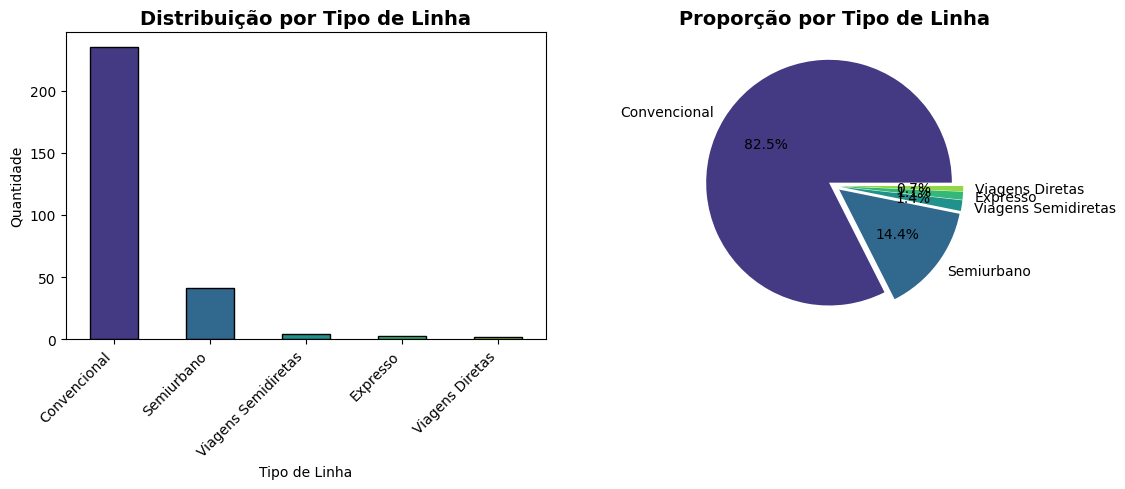

In [59]:
# Visualização gráfica da distribuição
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cores = sns.color_palette('viridis', n_colors=5)
df_empresas['TIPO_LINHA'].value_counts().plot(kind='bar', color=cores, edgecolor='black')
plt.title('Distribuição por Tipo de Linha', fontsize=14, fontweight='bold')
plt.xlabel('Tipo de Linha')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
df_empresas['TIPO_LINHA'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%', 
    colors=cores,
    explode=[0.05] * len(df_empresas['TIPO_LINHA'].unique())
)
plt.title('Proporção por Tipo de Linha', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.savefig('distribuicao_tipos_linha.png', dpi=150, bbox_inches='tight')
plt.show()


### 4.2 Extração de Features dos Dados

Vamos criar features a partir dos dados disponíveis para treinar nosso modelo.


In [60]:
def extrair_cidades_itinerario(itinerario):
    """
    Extrai origem e destino do itinerário.
    """
    if pd.isna(itinerario):
        return None, None
    
    # Padrões comuns: "Cidade A a Cidade B" ou "Cidade A / Cidade B"
    itinerario = str(itinerario)
    
    # Separar por " a " ou " / "
    if ' a ' in itinerario:
        partes = itinerario.split(' a ')
    elif ' / ' in itinerario:
        partes = itinerario.split(' / ')
    else:
        return itinerario.strip(), itinerario.strip()
    
    if len(partes) >= 2:
        origem = partes[0].strip()
        # Remover informações entre parênteses do destino
        destino = re.sub(r'\s*\(.*\)', '', partes[1]).strip()
        return origem, destino
    
    return partes[0].strip(), partes[0].strip()

# Extrair origem e destino
df_empresas[['ORIGEM', 'DESTINO']] = df_empresas['ITINERÁRIO'].apply(
    lambda x: pd.Series(extrair_cidades_itinerario(x))
)

print("Exemplos de origem e destino extraídos:")
df_empresas[['ITINERÁRIO', 'ORIGEM', 'DESTINO']].head(10)


Exemplos de origem e destino extraídos:


,ITINERÁRIO,ORIGEM,DESTINO
0,Goiânia a São Miguel do Araguaia (via GO-070 e GO-164),Goiânia,São Miguel do Araguaia
1,Goiânia a Adelândia,Goiânia,Adelândia
2,Goiânia a Americano do Brasil,Goiânia,Americano do Brasil
3,Goiânia a Aruanã,Goiânia,Aruanã
4,Goiânia a Britânia (via GO-060 e GO-326),Goiânia,Britânia
5,Goiânia a Jussara,Goiânia,Jussara
6,Goiânia a Novo Brasil,Goiânia,Novo Brasil
7,Goiânia a Anicuns,Goiânia,Anicuns
8,Goiânia a Claudinápolis,Goiânia,Claudinápolis
9,Goiânia a Santa Bárbara de Goiás,Goiânia,Santa Bárbara de Goiás


In [61]:
def extrair_codigo_empresa(numero_linha):
    """
    Extrai o código da empresa a partir do número da linha.
    Formato típico: XX.YYYY-ZZ onde XX é o código da empresa
    """
    if pd.isna(numero_linha):
        return '00'
    
    numero = str(numero_linha)
    match = re.match(r'^(\d+)', numero)
    if match:
        return match.group(1)
    return '00'

def extrair_numero_sequencial(numero_linha):
    """
    Extrai o número sequencial da linha.
    """
    if pd.isna(numero_linha):
        return 0
    
    numero = str(numero_linha)
    match = re.search(r'\.(\d+)', numero)
    if match:
        return int(match.group(1))
    return 0

def verificar_variante(numero_linha):
    """
    Verifica se a linha é uma variante (possui -01, -02, etc.)
    """
    if pd.isna(numero_linha):
        return 0
    
    numero = str(numero_linha)
    if re.search(r'-0[1-9]', numero):
        return 1
    return 0

def contar_vias(itinerario):
    """
    Conta quantas vias/rodovias são mencionadas no itinerário.
    """
    if pd.isna(itinerario):
        return 0
    
    itinerario = str(itinerario).upper()
    rodovias = re.findall(r'(GO-\d+|BR-\d+|DF-\d+)', itinerario)
    return len(rodovias)

def verificar_capital(itinerario):
    """
    Verifica se a linha passa por Goiânia.
    """
    if pd.isna(itinerario):
        return 0
    
    itinerario = str(itinerario).lower()
    if 'goiania' in itinerario or 'goiânia' in itinerario:
        return 1
    return 0

def verificar_anapolis(itinerario):
    """
    Verifica se a linha passa por Anápolis.
    """
    if pd.isna(itinerario):
        return 0
    
    itinerario = str(itinerario).lower()
    if 'anapolis' in itinerario or 'anápolis' in itinerario:
        return 1
    return 0

# Aplicar as funções de extração de features
df_empresas['CODIGO_EMPRESA'] = df_empresas['NÚMERO DA LINHA'].apply(extrair_codigo_empresa)
df_empresas['NUM_SEQUENCIAL'] = df_empresas['NÚMERO DA LINHA'].apply(extrair_numero_sequencial)
df_empresas['E_VARIANTE'] = df_empresas['NÚMERO DA LINHA'].apply(verificar_variante)
df_empresas['QTD_RODOVIAS'] = df_empresas['ITINERÁRIO'].apply(contar_vias)
df_empresas['PASSA_CAPITAL'] = df_empresas['ITINERÁRIO'].apply(verificar_capital)
df_empresas['PASSA_ANAPOLIS'] = df_empresas['ITINERÁRIO'].apply(verificar_anapolis)
df_empresas['TAM_ITINERARIO'] = df_empresas['ITINERÁRIO'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

print("Features extraídas com sucesso!")
df_empresas[['NÚMERO DA LINHA', 'ITINERÁRIO', 'CODIGO_EMPRESA', 'NUM_SEQUENCIAL', 
             'E_VARIANTE', 'QTD_RODOVIAS', 'PASSA_CAPITAL', 'PASSA_ANAPOLIS', 'TAM_ITINERARIO']].head(10)


Features extraídas com sucesso!


,NÚMERO DA LINHA,ITINERÁRIO,CODIGO_EMPRESA,NUM_SEQUENCIAL,E_VARIANTE,QTD_RODOVIAS,PASSA_CAPITAL,PASSA_ANAPOLIS,TAM_ITINERARIO
0,1959.162-00,Goiânia a São Miguel do Araguaia (via GO-070 e GO-164),1959,162,0,2,1,0,54
1,01.044-00,Goiânia a Adelândia,01,44,0,0,1,0,19
2,01.045-00,Goiânia a Americano do Brasil,01,45,0,0,1,0,29
3,01.046-00,Goiânia a Aruanã,01,46,0,0,1,0,16
4,01.047-00,Goiânia a Britânia (via GO-060 e GO-326),01,47,0,2,1,0,40
5,01.048-00,Goiânia a Jussara,01,48,0,0,1,0,17
6,01.049-00,Goiânia a Novo Brasil,01,49,0,0,1,0,21
7,01.050-00,Goiânia a Anicuns,01,50,0,0,1,0,17
8,01.051-00,Goiânia a Claudinápolis,01,51,0,0,1,0,23
9,01.052-00,Goiânia a Santa Bárbara de Goiás,01,52,0,0,1,0,32



TOP 5 EMPRESAS COM MAIOR NÚMERO DE LINHAS
NOME DA EMPRESA
Juarez Mendes de Melo          45
Viação Estrela Ltda.           35
Auto Viação Goianésia Ltda.    27
Expresso São Luiz Ltda.        19
Expresso União Ltda.           18
Name: count, dtype: int64


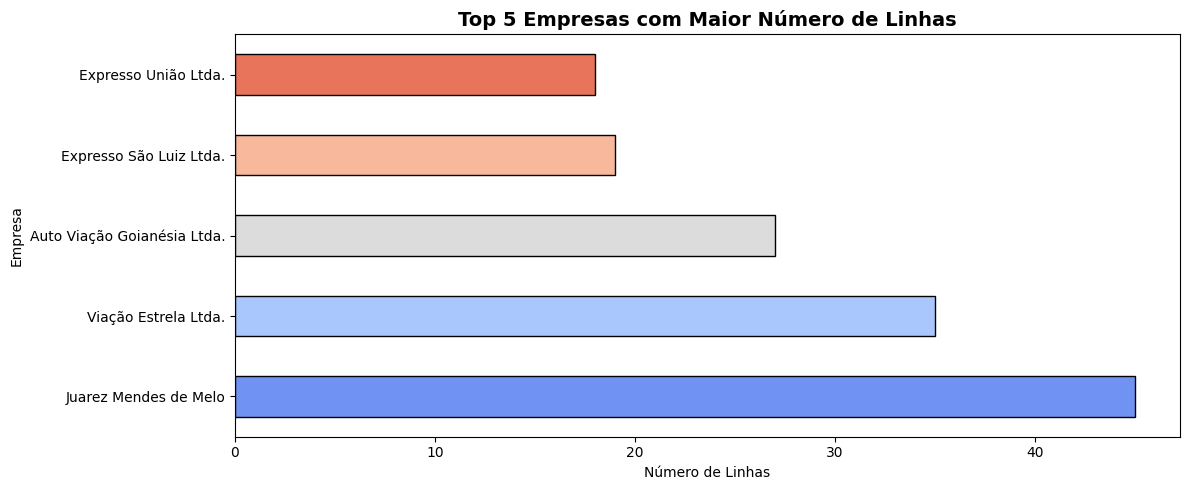

In [62]:
# Top 5 empresas com maior número de linhas
print("\n" + "=" * 80)
print("TOP 5 EMPRESAS COM MAIOR NÚMERO DE LINHAS")
print("=" * 80)
top_empresas = df_empresas['NOME DA EMPRESA'].value_counts().head(5)
print(top_empresas)

plt.figure(figsize=(12, 5))
cores_empresas = sns.color_palette('coolwarm', n_colors=5)
top_empresas.plot(kind='barh', color=cores_empresas, edgecolor='black')
plt.title('Top 5 Empresas com Maior Número de Linhas', fontsize=14, fontweight='bold')
plt.xlabel('Número de Linhas')
plt.ylabel('Empresa')
plt.tight_layout()
plt.savefig('top_empresas.png', dpi=150, bbox_inches='tight')
plt.show()


### 4.3 Enriquecimento com Dados de Terminais

Vamos enriquecer nossos dados com informações dos terminais rodoviários.


In [63]:
# Criar dicionário de propriedade dos terminais por município
df_terminais.columns = ['MUNICIPIO', 'PROPRIEDADE', 'ENTIDADE_GESTORA', 'SITUACAO', 'CONVENIO', 'VIGENCIA']

# Criar mapeamentos
propriedade_map = dict(zip(df_terminais['MUNICIPIO'].str.lower().str.strip(), 
                           df_terminais['PROPRIEDADE']))
situacao_map = dict(zip(df_terminais['MUNICIPIO'].str.lower().str.strip(), 
                        df_terminais['SITUACAO']))

def obter_propriedade_terminal(cidade):
    """
    Retorna a propriedade do terminal (Estado, Município, Particular)
    """
    if pd.isna(cidade):
        return 'Desconhecido'
    
    cidade_lower = str(cidade).lower().strip()
    return propriedade_map.get(cidade_lower, 'Desconhecido')

def verificar_terminal_operando(cidade):
    """
    Verifica se o terminal está operando
    """
    if pd.isna(cidade):
        return 0
    
    cidade_lower = str(cidade).lower().strip()
    situacao = situacao_map.get(cidade_lower, '')
    return 1 if 'OPERANDO' in str(situacao).upper() else 0

# Aplicar mapeamentos
df_empresas['PROP_TERMINAL_ORIGEM'] = df_empresas['ORIGEM'].apply(obter_propriedade_terminal)
df_empresas['PROP_TERMINAL_DESTINO'] = df_empresas['DESTINO'].apply(obter_propriedade_terminal)
df_empresas['TERMINAL_ORIGEM_OPERA'] = df_empresas['ORIGEM'].apply(verificar_terminal_operando)
df_empresas['TERMINAL_DESTINO_OPERA'] = df_empresas['DESTINO'].apply(verificar_terminal_operando)

print("Features de terminais adicionadas!")
df_empresas[['ORIGEM', 'DESTINO', 'PROP_TERMINAL_ORIGEM', 'PROP_TERMINAL_DESTINO', 
             'TERMINAL_ORIGEM_OPERA', 'TERMINAL_DESTINO_OPERA']].head(10)


Features de terminais adicionadas!


,ORIGEM,DESTINO,PROP_TERMINAL_ORIGEM,PROP_TERMINAL_DESTINO,TERMINAL_ORIGEM_OPERA,TERMINAL_DESTINO_OPERA
0,Goiânia,São Miguel do Araguaia,Estado,Estado,1,1
1,Goiânia,Adelândia,Estado,Estado,1,1
2,Goiânia,Americano do Brasil,Estado,Estado,1,1
3,Goiânia,Aruanã,Estado,Município,1,1
4,Goiânia,Britânia,Estado,Estado,1,1
5,Goiânia,Jussara,Estado,Município,1,1
6,Goiânia,Novo Brasil,Estado,Estado,1,1
7,Goiânia,Anicuns,Estado,Estado,1,1
8,Goiânia,Claudinápolis,Estado,Desconhecido,1,0
9,Goiânia,Santa Bárbara de Goiás,Estado,Estado,1,1


## 5. Pré-processamento para o Modelo de Deep Learning


In [64]:
# Remover linhas com valores nulos nas colunas importantes
df_modelo = df_empresas.dropna(subset=['NOME DA EMPRESA', 'TIPO_LINHA']).copy()

print(f"Registros para modelagem: {len(df_modelo)}")

# Verificar distribuição final das classes
print("\nDistribuição das classes:")
print(df_modelo['TIPO_LINHA'].value_counts())


Registros para modelagem: 285

Distribuição das classes:
TIPO_LINHA
Convencional           235
Semiurbano              41
Viagens Semidiretas      4
Expresso                 3
Viagens Diretas          2
Name: count, dtype: int64


In [65]:
# Definir features numéricas e categóricas
features_numericas = [
    'NUM_SEQUENCIAL',
    'E_VARIANTE',
    'QTD_RODOVIAS',
    'PASSA_CAPITAL',
    'PASSA_ANAPOLIS',
    'TAM_ITINERARIO',
    'TERMINAL_ORIGEM_OPERA',
    'TERMINAL_DESTINO_OPERA'
]

features_categoricas = [
    'CODIGO_EMPRESA',
    'PROP_TERMINAL_ORIGEM',
    'PROP_TERMINAL_DESTINO'
]

print("Features numéricas:", features_numericas)
print("\nFeatures categóricas:", features_categoricas)


Features numéricas: ['NUM_SEQUENCIAL', 'E_VARIANTE', 'QTD_RODOVIAS', 'PASSA_CAPITAL', 'PASSA_ANAPOLIS', 'TAM_ITINERARIO', 'TERMINAL_ORIGEM_OPERA', 'TERMINAL_DESTINO_OPERA']

Features categóricas: ['CODIGO_EMPRESA', 'PROP_TERMINAL_ORIGEM', 'PROP_TERMINAL_DESTINO']


In [66]:
# Preparar os dados
# Codificar a variável alvo
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_modelo['TIPO_LINHA'])

print("Mapeamento das classes:")
for i, classe in enumerate(label_encoder.classes_):
    print(f"  {i}: {classe}")

# Converter para one-hot encoding (necessário para classificação multiclasse)
num_classes = len(label_encoder.classes_)
y_onehot = to_categorical(y, num_classes=num_classes)

print(f"\nFormato de y_onehot: {y_onehot.shape}")


Mapeamento das classes:
  0: Convencional
  1: Expresso
  2: Semiurbano
  3: Viagens Diretas
  4: Viagens Semidiretas

Formato de y_onehot: (285, 5)


In [67]:
# Preparar features X
# Criar dataframe com features numéricas
X_num = df_modelo[features_numericas].copy()

# Codificar features categóricas com One-Hot Encoding
# dtype=int garante que os valores sejam numéricos (0 e 1)
X_cat = pd.get_dummies(df_modelo[features_categoricas], prefix=features_categoricas, dtype=int)

# Concatenar features
X = pd.concat([X_num, X_cat], axis=1)

# Preencher valores nulos com 0 e converter tudo para float
X = X.fillna(0).astype(float)

print(f"Formato final de X: {X.shape}")
print(f"Tipos de dados:\n{X.dtypes.value_counts()}")
print(f"\nPrimeiras 15 features: {X.columns.tolist()[:15]}...")
X.head()


Formato final de X: (285, 47)
Tipos de dados:
float64    47
Name: count, dtype: int64

Primeiras 15 features: ['NUM_SEQUENCIAL', 'E_VARIANTE', 'QTD_RODOVIAS', 'PASSA_CAPITAL', 'PASSA_ANAPOLIS', 'TAM_ITINERARIO', 'TERMINAL_ORIGEM_OPERA', 'TERMINAL_DESTINO_OPERA', 'CODIGO_EMPRESA_01', 'CODIGO_EMPRESA_02', 'CODIGO_EMPRESA_03', 'CODIGO_EMPRESA_04', 'CODIGO_EMPRESA_05', 'CODIGO_EMPRESA_06', 'CODIGO_EMPRESA_07']...


,NUM_SEQUENCIAL,E_VARIANTE,QTD_RODOVIAS,PASSA_CAPITAL,PASSA_ANAPOLIS,TAM_ITINERARIO,TERMINAL_ORIGEM_OPERA,TERMINAL_DESTINO_OPERA,CODIGO_EMPRESA_01,CODIGO_EMPRESA_02,CODIGO_EMPRESA_03,CODIGO_EMPRESA_04,CODIGO_EMPRESA_05,CODIGO_EMPRESA_06,CODIGO_EMPRESA_07,CODIGO_EMPRESA_08,CODIGO_EMPRESA_09,CODIGO_EMPRESA_10,CODIGO_EMPRESA_11,CODIGO_EMPRESA_12,CODIGO_EMPRESA_13,CODIGO_EMPRESA_1332,CODIGO_EMPRESA_14,CODIGO_EMPRESA_15,CODIGO_EMPRESA_16,CODIGO_EMPRESA_19,CODIGO_EMPRESA_1959,CODIGO_EMPRESA_2626,CODIGO_EMPRESA_3381,CODIGO_EMPRESA_3631,CODIGO_EMPRESA_6156,CODIGO_EMPRESA_6184,CODIGO_EMPRESA_6229,CODIGO_EMPRESA_6553,CODIGO_EMPRESA_6774,CODIGO_EMPRESA_7308,CODIGO_EMPRESA_8454,CODIGO_EMPRESA_9019,CODIGO_EMPRESA_9200,CODIGO_EMPRESA_9414,PROP_TERMINAL_ORIGEM_Desconhecido,PROP_TERMINAL_ORIGEM_Estado,PROP_TERMINAL_ORIGEM_Município,PROP_TERMINAL_DESTINO_Desconhecido,PROP_TERMINAL_DESTINO_Estado,PROP_TERMINAL_DESTINO_Município,PROP_TERMINAL_DESTINO_Particular
0,162.0,0.0,2.0,1.0,0.0,54.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,44.0,0.0,0.0,1.0,0.0,19.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,45.0,0.0,0.0,1.0,0.0,29.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,46.0,0.0,0.0,1.0,0.0,16.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,47.0,0.0,2.0,1.0,0.0,40.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [68]:
# Normalização das features numéricas
scaler = StandardScaler()

# Aplicar normalização apenas nas features numéricas originais
X_scaled = X.copy()
X_scaled[features_numericas] = scaler.fit_transform(X[features_numericas])

print("Estatísticas após normalização (features numéricas):")
X_scaled[features_numericas].describe()


Estatísticas após normalização (features numéricas):


,NUM_SEQUENCIAL,E_VARIANTE,QTD_RODOVIAS,PASSA_CAPITAL,PASSA_ANAPOLIS,TAM_ITINERARIO,TERMINAL_ORIGEM_OPERA,TERMINAL_DESTINO_OPERA
count,2.850000e+02,2.850000e+02,2.850000e+02,2.850000e+02,2.850000e+02,2.850000e+02,2.850000e+02,2.850000e+02
mean,2.804774e-17,-2.493132e-17,-3.739699e-17,-6.232831e-18,-2.493132e-17,-4.362982e-17,9.349247e-17,-6.232831e-18
std,1.001759e+00,1.001759e+00,1.001759e+00,1.001759e+00,1.001759e+00,1.001759e+00,1.001759e+00,1.001759e+00
min,-1.239121e+00,-4.612656e-01,-3.388155e-01,-9.689043e-01,-3.300749e-01,-1.366394e+00,-1.673320e+00,-1.242837e+00
25%,-1.003243e+00,-4.612656e-01,-3.388155e-01,-9.689043e-01,-3.300749e-01,-8.978693e-01,-1.673320e+00,-1.242837e+00
50%,7.163845e-01,-4.612656e-01,-3.388155e-01,-9.689043e-01,-3.300749e-01,-1.950818e-01,5.976143e-01,8.046110e-01
75%,1.007428e+00,-4.612656e-01,-3.388155e-01,1.032094e+00,-3.300749e-01,6.638808e-01,5.976143e-01,8.046110e-01
max,1.184336e+00,2.167948e+00,3.952847e+00,1.032094e+00,3.029616e+00,2.772244e+00,5.976143e-01,8.046110e-01


In [69]:
# Converter todas as colunas para float32 (necessário para TensorFlow)
X_scaled_array = X_scaled.astype(np.float32).values

# Divisão em treino, validação e teste (60-20-20)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_scaled_array, y_onehot, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)

print(f"Conjunto de Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Conjunto de Validação: {X_val.shape[0]} amostras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Conjunto de Teste: {X_test.shape[0]} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nNúmero de features: {X_train.shape[1]}")
print(f"Tipo de dados: {X_train.dtype}")


Conjunto de Treino: 171 amostras (60.0%)
Conjunto de Validação: 57 amostras (20.0%)
Conjunto de Teste: 57 amostras (20.0%)

Número de features: 47
Tipo de dados: float32


## 6. Construção do Modelo MLP (Perceptron Multicamadas)

### 6.1 Justificativa da Arquitetura

A arquitetura do modelo foi projetada considerando:

1. **Camada de Entrada**: Dimensão igual ao número de features após pré-processamento
2. **Camadas Ocultas**: 
   - Dense(128) + ReLU + BatchNormalization + Dropout(0.3)
   - Dense(64) + ReLU + BatchNormalization + Dropout(0.3)
   - Dense(32) + ReLU + Dropout(0.2)
3. **Camada de Saída**: Dense(5) + Softmax (5 classes)

**Técnicas utilizadas:**
- **BatchNormalization**: Estabiliza e acelera o treinamento
- **Dropout**: Previne overfitting através de regularização
- **ReLU**: Função de ativação eficiente para camadas ocultas
- **Softmax**: Função de ativação para classificação multiclasse


In [70]:
def criar_modelo_mlp(input_dim, num_classes):
    """
    Cria e retorna o modelo MLP para classificação de tipos de linha.
    
    Arquitetura:
    - Input Layer: input_dim features
    - Hidden Layer 1: 128 neurônios + ReLU + BatchNorm + Dropout(0.3)
    - Hidden Layer 2: 64 neurônios + ReLU + BatchNorm + Dropout(0.3)
    - Hidden Layer 3: 32 neurônios + ReLU + Dropout(0.2)
    - Output Layer: num_classes neurônios + Softmax
    
    Args:
        input_dim: Número de features de entrada
        num_classes: Número de classes de saída
    
    Returns:
        model: Modelo Keras compilado
    """
    model = Sequential([
        # Camada de entrada + primeira camada oculta
        Dense(128, input_dim=input_dim, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Segunda camada oculta
        Dense(64, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Terceira camada oculta
        Dense(32, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.2),
        
        # Camada de saída
        Dense(num_classes, activation='softmax')
    ])
    
    # Compilar modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Criar modelo
modelo = criar_modelo_mlp(X_train.shape[1], num_classes)

# Exibir arquitetura
modelo.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,413 (68.02 KB)

 Trainable params: 17,029 (66.52 KB)

 Non-trainable params: 384 (1.50 KB)

## 7. Treinamento do Modelo


In [71]:
# Callbacks para o treinamento
callbacks = [
    # Early Stopping: para o treino se não houver melhora
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    # Redução da taxa de aprendizado quando estagnado
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

print("Callbacks configurados:")
print("- EarlyStopping: paciência de 15 épocas")
print("- ReduceLROnPlateau: reduz LR em 50% após 5 épocas sem melhora")


Callbacks configurados:
- EarlyStopping: paciência de 15 épocas
- ReduceLROnPlateau: reduz LR em 50% após 5 épocas sem melhora


In [72]:
# Calcular pesos das classes para lidar com desbalanceamento
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weight_dict = dict(enumerate(class_weights))

print("Pesos das classes (para balanceamento):")
for i, weight in class_weight_dict.items():
    print(f"  Classe {i} ({label_encoder.classes_[i]}): {weight:.4f}")


Pesos das classes (para balanceamento):
  Classe 0 (Convencional): 0.2948
  Classe 1 (Expresso): 21.3750
  Classe 2 (Semiurbano): 1.9432
  Classe 3 (Viagens Diretas): 21.3750


In [73]:
# Treinamento do modelo
print("=" * 80)
print("INICIANDO TREINAMENTO")
print("=" * 80)

historico = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("\nTreinamento concluído!")


INICIANDO TREINAMENTO
Epoch 1/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.3626 - loss: 1.7338 - val_accuracy: 0.1228 - val_loss: 1.9276 - learning_rate: 0.0010
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4269 - loss: 1.9995 - val_accuracy: 0.2807 - val_loss: 1.6495 - learning_rate: 0.0010
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4620 - loss: 1.4273 - val_accuracy: 0.3333 - val_loss: 1.4264 - learning_rate: 0.0010
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5146 - loss: 1.4467 - val_accuracy: 0.5439 - val_loss: 1.2540 - learning_rate: 0.0010
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5439 - loss: 1.2304 - val_accuracy: 0.6842 - val_loss: 1.1317 - learning_rate: 0.0010
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5673 - loss: 1.1501 - val_accuracy: 0.7018 - val_loss: 1.0268 - learning_rate: 0.0010
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5906 -

## 8. Avaliação do Modelo


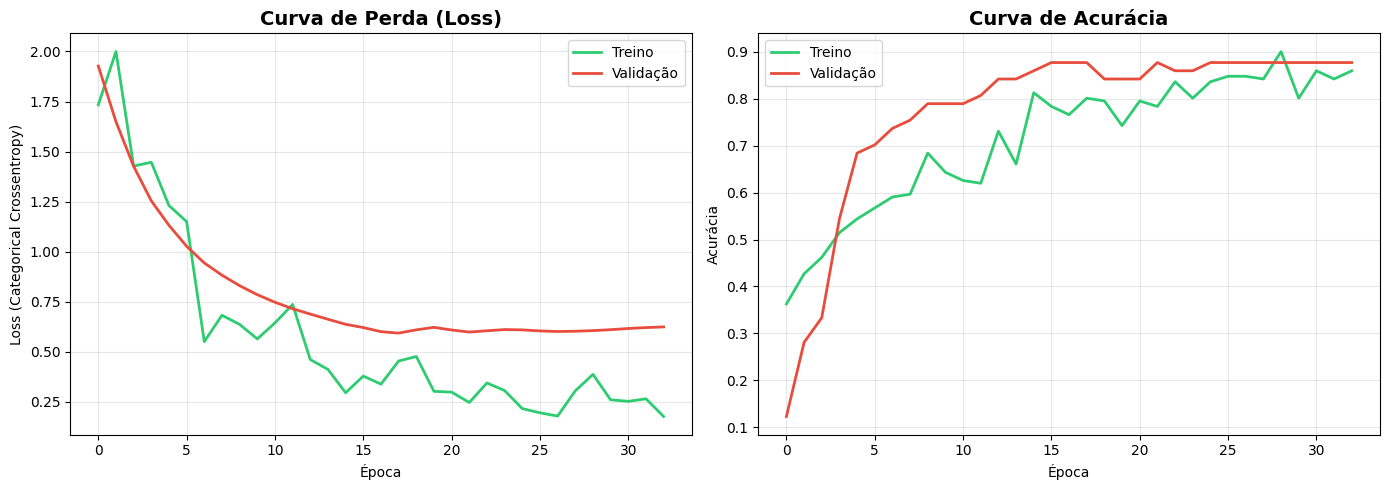

In [74]:
# Plotar curvas de aprendizado
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Curva de Loss
axes[0].plot(historico.history['loss'], label='Treino', linewidth=2, color='#2ecc71')
axes[0].plot(historico.history['val_loss'], label='Validação', linewidth=2, color='#e74c3c')
axes[0].set_title('Curva de Perda (Loss)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (Categorical Crossentropy)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Curva de Acurácia
axes[1].plot(historico.history['accuracy'], label='Treino', linewidth=2, color='#2ecc71')
axes[1].plot(historico.history['val_accuracy'], label='Validação', linewidth=2, color='#e74c3c')
axes[1].set_title('Curva de Acurácia', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Acurácia')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('curvas_aprendizado.png', dpi=150, bbox_inches='tight')
plt.show()


In [75]:
# Avaliação no conjunto de teste
print("=" * 80)
print("AVALIAÇÃO NO CONJUNTO DE TESTE")
print("=" * 80)

# Métricas no conjunto de teste
loss_teste, acc_teste = modelo.evaluate(X_test, y_test, verbose=0)

print(f"\nLoss no Teste: {loss_teste:.4f}")
print(f"Acurácia no Teste: {acc_teste:.4f} ({acc_teste*100:.2f}%)")


AVALIAÇÃO NO CONJUNTO DE TESTE

Loss no Teste: 0.5776
Acurácia no Teste: 0.7719 (77.19%)


In [76]:
# Predições no conjunto de teste
y_pred_prob = modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Relatório de classificação
# Usar labels para garantir que todas as classes sejam consideradas
print("\n" + "=" * 80)
print("RELATÓRIO DE CLASSIFICAÇÃO")
print("=" * 80)
print(classification_report(
    y_true, 
    y_pred, 
    labels=range(len(label_encoder.classes_)),
    target_names=label_encoder.classes_,
    zero_division=0  # Evita warnings para classes sem amostras
))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

RELATÓRIO DE CLASSIFICAÇÃO
                     precision    recall  f1-score   support

       Convencional       1.00      0.79      0.88        47
           Expresso       0.00      0.00      0.00         1
         Semiurbano       0.58      0.88      0.70         8
    Viagens Diretas       0.00      0.00      0.00         0
Viagens Semidiretas       0.00      0.00      0.00         1

           accuracy                           0.77        57
          macro avg       0.32      0.33      0.32        57
       weighted avg       0.91      0.77      0.82        57



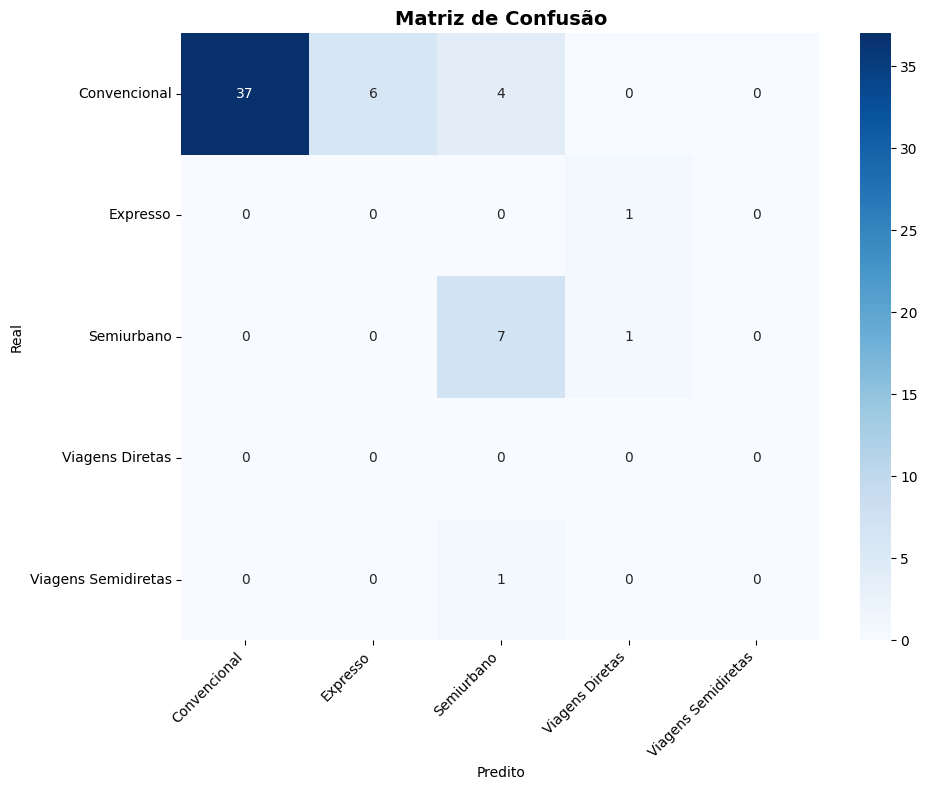

In [77]:
# Matriz de Confusão
# Especificar labels para garantir que todas as classes apareçam
cm = confusion_matrix(y_true, y_pred, labels=range(len(label_encoder.classes_)))

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusão', fontsize=14, fontweight='bold')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('matriz_confusao.png', dpi=150, bbox_inches='tight')
plt.show()


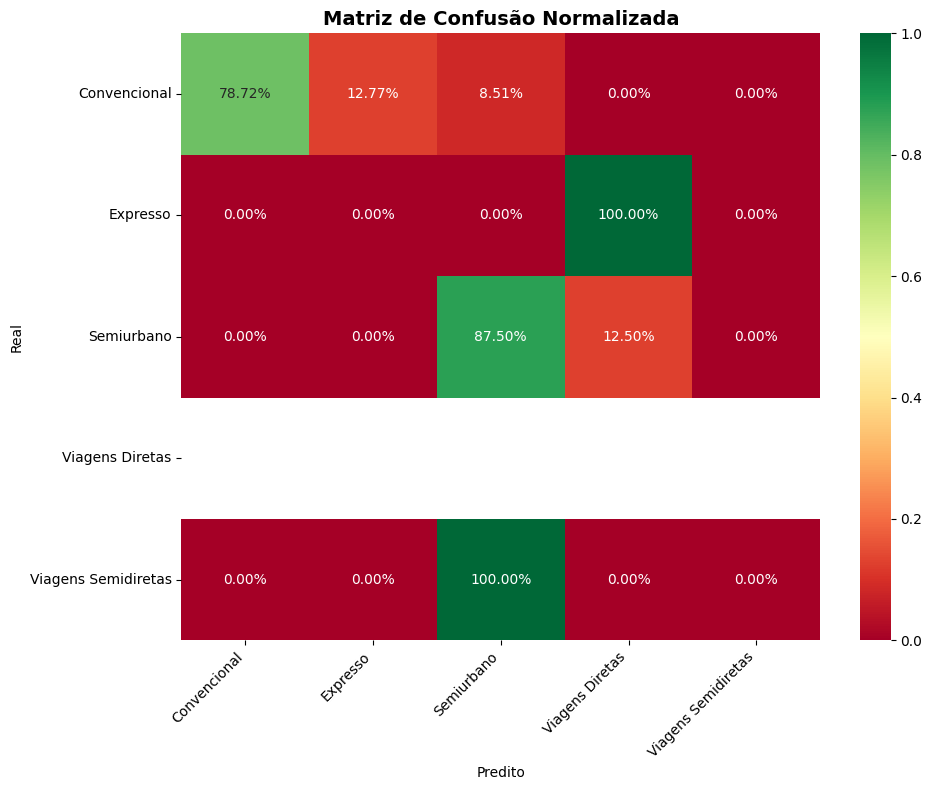

In [78]:
# Matriz de confusão normalizada (percentual)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2%', 
    cmap='RdYlGn',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusão Normalizada', fontsize=14, fontweight='bold')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('matriz_confusao_normalizada.png', dpi=150, bbox_inches='tight')
plt.show()


## 9. Análise dos Resultados


In [79]:
# Resumo dos resultados
print("=" * 80)
print("RESUMO DOS RESULTADOS")
print("=" * 80)

# Métricas por conjunto
loss_train, acc_train = modelo.evaluate(X_train, y_train, verbose=0)
loss_val, acc_val = modelo.evaluate(X_val, y_val, verbose=0)

print(f"\n{'Conjunto':<15} {'Loss':>10} {'Acurácia':>12}")
print("-" * 40)
print(f"{'Treino':<15} {loss_train:>10.4f} {acc_train*100:>11.2f}%")
print(f"{'Validação':<15} {loss_val:>10.4f} {acc_val*100:>11.2f}%")
print(f"{'Teste':<15} {loss_teste:>10.4f} {acc_teste*100:>11.2f}%")


RESUMO DOS RESULTADOS

Conjunto              Loss     Acurácia
----------------------------------------
Treino              0.3399       92.40%
Validação           0.5930       87.72%
Teste               0.5776       77.19%


In [80]:
# Análise de erros
from collections import Counter

print("\n" + "=" * 80)
print("ANÁLISE DE ERROS")
print("=" * 80)

# Encontrar índices de predições erradas
erros_idx = np.where(y_pred != y_true)[0]

print(f"\nTotal de erros: {len(erros_idx)} de {len(y_test)} ({len(erros_idx)/len(y_test)*100:.2f}%)")

# Análise de quais classes são mais confundidas
print("\nConfusões mais frequentes:")
confusoes = [(label_encoder.classes_[y_true[i]], label_encoder.classes_[y_pred[i]]) 
             for i in erros_idx]
confusoes_count = Counter(confusoes)

for (real, pred), count in confusoes_count.most_common(10):
    print(f"  {real} → {pred}: {count} vezes")



ANÁLISE DE ERROS

Total de erros: 13 de 57 (22.81%)

Confusões mais frequentes:
  Convencional → Expresso: 6 vezes
  Convencional → Semiurbano: 4 vezes
  Viagens Semidiretas → Semiurbano: 1 vezes
  Semiurbano → Viagens Diretas: 1 vezes
  Expresso → Viagens Diretas: 1 vezes


## 10. Salvamento do Modelo


In [81]:
# Salvar modelo treinado
import pickle

modelo.save('modelo_mlp_classificacao_linhas.h5')
print("Modelo salvo em 'modelo_mlp_classificacao_linhas.h5'")

# Salvar o encoder e scaler para uso futuro
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
    
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
print("LabelEncoder e StandardScaler salvos em arquivos .pkl")


Modelo salvo em 'modelo_mlp_classificacao_linhas.h5'
LabelEncoder e StandardScaler salvos em arquivos .pkl


## 11. Demonstração de Uso do Modelo


In [82]:
def prever_tipo_linha(modelo, features, label_encoder):
    """
    Realiza a predição do tipo de linha.
    
    Args:
        modelo: Modelo treinado
        features: Array com as features processadas
        label_encoder: LabelEncoder para decodificar a classe
    
    Returns:
        tuple: (classe_predita, probabilidades)
    """
    prob = modelo.predict(features, verbose=0)
    classe_idx = np.argmax(prob, axis=1)
    classe_nome = label_encoder.inverse_transform(classe_idx)
    
    return classe_nome, prob

# Exemplo de predição com algumas amostras do conjunto de teste
print("=" * 80)
print("EXEMPLOS DE PREDIÇÕES")
print("=" * 80)

# Selecionar 5 amostras aleatórias do teste
indices_exemplo = np.random.choice(len(X_test), 5, replace=False)

for i, idx in enumerate(indices_exemplo):
    amostra = X_test[idx:idx+1]
    classe_real = label_encoder.classes_[y_true[idx]]
    classe_pred, probs = prever_tipo_linha(modelo, amostra, label_encoder)
    
    print(f"\nExemplo {i+1}:")
    print(f"  Classe Real: {classe_real}")
    print(f"  Classe Predita: {classe_pred[0]}")
    print(f"  Probabilidades:")
    for j, classe in enumerate(label_encoder.classes_):
        print(f"    {classe}: {probs[0][j]*100:.2f}%")


EXEMPLOS DE PREDIÇÕES

Exemplo 1:
  Classe Real: Convencional
  Classe Predita: Convencional
  Probabilidades:
    Convencional: 51.84%
    Expresso: 26.23%
    Semiurbano: 3.25%
    Viagens Diretas: 10.66%
    Viagens Semidiretas: 8.01%

Exemplo 2:
  Classe Real: Convencional
  Classe Predita: Convencional
  Probabilidades:
    Convencional: 71.09%
    Expresso: 4.58%
    Semiurbano: 17.83%
    Viagens Diretas: 2.47%
    Viagens Semidiretas: 4.04%

Exemplo 3:
  Classe Real: Convencional
  Classe Predita: Convencional
  Probabilidades:
    Convencional: 69.87%
    Expresso: 5.52%
    Semiurbano: 5.37%
    Viagens Diretas: 11.92%
    Viagens Semidiretas: 7.31%

Exemplo 4:
  Classe Real: Convencional
  Classe Predita: Convencional
  Probabilidades:
    Convencional: 65.34%
    Expresso: 5.59%
    Semiurbano: 25.87%
    Viagens Diretas: 2.25%
    Viagens Semidiretas: 0.95%

Exemplo 5:
  Classe Real: Convencional
  Classe Predita: Convencional
  Probabilidades:
    Convencional: 95.06%
   

## 12. Conclusões

### Principais Resultados:

1. **Modelo Implementado**: Perceptron Multicamadas (MLP) com 3 camadas ocultas
2. **Classes Classificadas**: Convencional, Semiurbano, Expresso, Viagens Diretas, Viagens Semidiretas
3. **Features Utilizadas**: Características extraídas dos itinerários, terminais e metadados das linhas

### Arquitetura do Modelo:
- **Entrada**: Features numéricas e categóricas codificadas
- **Camadas Ocultas**: 128 → 64 → 32 neurônios com ReLU, BatchNormalization e Dropout
- **Saída**: 5 classes com Softmax

### Técnicas Aplicadas:
- **Pré-processamento**: StandardScaler para normalização, One-Hot Encoding para variáveis categóricas
- **Regularização**: Dropout (0.2-0.3) para evitar overfitting
- **Otimização**: Adam optimizer com redução adaptativa de learning rate
- **Balanceamento**: Class weights para lidar com classes desbalanceadas

### Formulação Matemática do Modelo:

O modelo MLP realiza as seguintes operações:

1. **Primeira camada oculta:**
   $$h_1 = ReLU(W_1 \cdot x + b_1)$$

2. **Segunda camada oculta:**
   $$h_2 = ReLU(W_2 \cdot h_1 + b_2)$$

3. **Terceira camada oculta:**
   $$h_3 = ReLU(W_3 \cdot h_2 + b_3)$$

4. **Camada de saída:**
   $$\hat{y} = softmax(W_4 \cdot h_3 + b_4)$$

5. **Função de perda (Cross-Entropy):**
   $$L = -\sum_{i} y_i \log(\hat{y}_i)$$

### Aplicações Práticas:
1. Classificação automática de novas linhas de transporte
2. Apoio à tomada de decisão regulatória
3. Identificação de inconsistências cadastrais
4. Otimização do planejamento de transporte intermunicipal

---

**Nota**: O desempenho do modelo pode ser impactado pelo desbalanceamento natural das classes (maioria das linhas são convencionais). Técnicas adicionais como SMOTE ou data augmentation podem ser exploradas para melhorar a classificação das classes minoritárias.


## Referências Bibliográficas

1. AGR - Agência Goiana de Regulação, Controle e Fiscalização de Serviços Públicos. **Dados Abertos**. Disponível em: https://dadosabertos.go.gov.br/

2. GOODFELLOW, I.; BENGIO, Y.; COURVILLE, A. **Deep Learning**. MIT Press, 2016.

3. CHOLLET, F. **Deep Learning with Python**. Manning Publications, 2021.

4. KERAS Documentation. Disponível em: https://keras.io/

5. TensorFlow Documentation. Disponível em: https://www.tensorflow.org/

6. BRASIL. **Resolução Nº 7, de 18 de dezembro de 2018**. Estabelece as Diretrizes para a Extensão na Educação Superior Brasileira. Ministério da Educação/Conselho Nacional de Educação.
